In [1]:
"""
    Copyright (c) 2021 Olivier Leblanc

    Permission is hereby granted, free of charge, to any person obtaining
    a copy of this software and associated documentation files (the "Software"),
    to deal in the Software without restriction, including without limitation
    the rights to use, copy, modify, merge, publish, distribute, and to permit
    persons to whom the Software is furnished to do so.
    However, anyone intending to sublicense and/or sell copies of the Software
    will require the official permission of the author.
    ----------------------------------------------------------------------------

    Author : Olivier Leblanc
    Date : 02/06/2021

    Code description :
    __________________
    Analyzes the impact of multiplicity in the observations
    in a compressive sensing context.
"""
import matplotlib.pyplot as plt
import numpy as np
import pyunlocbox
from pyunlocbox import functions, solvers, acceleration
import time

import sys, os
def updir(d, n):
  for _ in range(n):
    d = os.path.dirname(d)
  return d
sys.path.append(os.path.join(updir(os.getcwd(),2),'utils'))

from interferometric_lensless_imaging import * # ROP projectors, rmdiag,...
from graphics import set_plot_params, subplot_axs, labels
from shepp_logan import phantom
set_plot_params() # Set the plot params

Considering the observation vector $\mathbf y $ has multiplicity, 
this means the observation matrix $\mathbf{A}$ contains the 
associated rows with the same multiplicity, e.g.:
$$
\begin{equation}
    \mathbf{A} = \begin{bmatrix}
        \mathbf{a}_1 \\ \vdots \\ \mathbf{a}_1 \\ \mathbf{a}_2 \\ 
        \vdots \\ \mathbf{a}_M 
    \end{bmatrix}
\end{equation}
$$
Expressing $\mathbf{A}$ as a combination of the rows of a compact 
matrix $\mathbf{A}_c$, we have:
$$
\begin{align} 
\begin{split}
    \mathbf{A} = \begin{bmatrix}
        \mathbf{1}_{w1} & \mathbf{0} & \cdots \\
        \mathbf{0}      & \mathbf{1}_{w2} & \mathbf{0} \\
        \vdots      & \mathbf{0}      & \ddots
    \end{bmatrix} 
    \begin{bmatrix}
        \mathbf{a}_1 \\ \mathbf{a}_2 \\ \vdots \\ \mathbf{a}_M
    \end{bmatrix}
    = \mathbf{M A}_c
\end{split}
\end{align}
$$
Where $\mathbf{1}_{w1}$ is a column-vector with $w1$ ones, with 
$w1$ the multiplicity associated with observation $y_1$. \\
Introducing Eq.~(\ref{eq: compacting_A}) in the gradient of 
the data fidelity term, this yiels:
$$
\begin{equation} 
    \nabla f(\mathbf{u}) = \mathbf{A}^H (\mathbf{Au}-\mathbf{y}) = 
    \mathbf{A}_c^H \mathbf{M}^H (\mathbf{M} \mathbf{A}_c \mathbf{u} - \mathbf{y}) = 
    \mathbf{A}_c^H \text{diag}(\mathbf{w}) 
    (\mathbf{A}_c \mathbf{u} - \mathbf{y}) 
\end{equation}
$$
We see that 
multiplicity in the observations will bias the gradient
search direction.

## Sparse signal $\mathbf{X}$

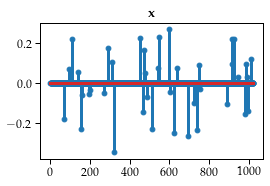

In [2]:
n = 1024 # signal size
S = 40 # sparsity
x = np.zeros(n)
I = np.random.permutation(n)
x[I[0:S]] = np.random.normal(size=S)
x = x / np.linalg.norm(x)

plt.figure(figsize=(4,2.5))
plt.stem(x)
plt.title(r'$\mathbf{x}$')
plt.show()

## Random measurement matrix $\mathbf{A}$

Number of measurements: 278
Compression ratio: 3.68


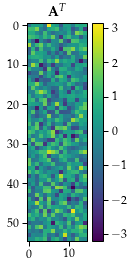

In [3]:
m = int(np.ceil(S * np.log(n)))
print('Number of measurements: {}'.format(m))
print('Compression ratio: {:3.2f}'.format(float(n) / m))

# np.random.seed(1)  # Reproducible results.
Ac = np.random.normal(size=(m, n))

indmax = 15
plt.figure(figsize=(2,4))
plt.imshow(Ac[:indmax, :round(indmax*n/m)].T, cmap='viridis')
plt.colorbar()
plt.title(r'$\mathbf{A}^T$')
plt.show()

## Measured signal $\mathbf{y}_c$

Solution found after 93 iterations:
    objective function f(sol) = 4.874810e+00
    stopping criterion: RTOL
Solution found after 500 iterations:
    objective function f(sol) = 1.334486e+01
    stopping criterion: MAXIT


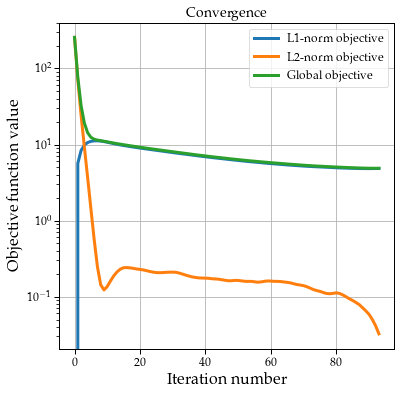

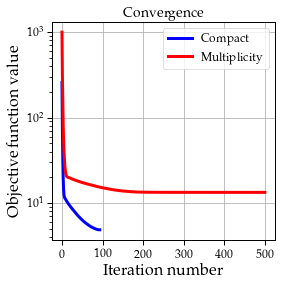

In [5]:
"_______________________"
"_________Compact_______"

x = np.zeros(n) # random sparse signal
I = np.random.permutation(n)
x[I[0:S]] = np.random.normal(size=S)
x = x / np.linalg.norm(x)
Ac = np.random.normal(size=(m, n)) # observation matrix
yc = np.dot(Ac, x) # observations

"Reconstruction"
tau = 1.0
f1 = functions.norm_l1(lambda_=tau)
f2 = functions.norm_l2(y=yc, A=Ac)
step = 0.5 / np.linalg.norm(Ac, ord=2)**2
solver = solvers.forward_backward(step=step)
x0 = np.zeros(n)
retc = solvers.solve([f1, f2], x0, solver, rtol=1e-4, maxit=300)
objectivec = np.array(retc['objective'])


plt.figure()
plt.semilogy(objectivec[:, 0], label='L1-norm objective')
plt.semilogy(objectivec[:, 1], label='L2-norm objective')
plt.semilogy(np.sum(objectivec, axis=1), label='Global objective')
plt.grid(True)
plt.title('Convergence')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Objective function value')

"_______________________"
"___With multiplicity___"

w = np.random.randint(1,8, size=m) # weight vector
"Construction of the observation matrix"
A = np.zeros( (np.sum(w),n) ) 
ind=0
for i,wi in enumerate(w):
    A[ind:ind+wi,:] = Ac[i,:]
    ind+=wi

sig = 1e-1
noise = sig*np.random.randn(np.sum(w))
y = np.dot(A, x) + noise # Observation

"Reconstruction"
tau = 1.0
f1 = functions.norm_l1(lambda_=tau)
f2 = functions.norm_l2(y=y, A=A)
step = 0.5 / np.linalg.norm(A, ord=2)**2
solver = solvers.forward_backward(step=step)
x0 = np.zeros(n)
ret = solvers.solve([f1, f2], x0, solver, rtol=1e-8, maxit=500)
objective = np.array(ret['objective'])

"_______________________"
"_______Comparison______"
plt.figure(figsize=(4,4))
plt.semilogy(np.sum(objectivec, axis=1), 'b', label='Compact')
plt.semilogy(np.sum(objective, axis=1), 'r', label='Multiplicity')
plt.grid(True)
plt.title('Convergence')
plt.legend()
plt.xlabel('Iteration number')
plt.ylabel('Objective function value')
plt.show()